In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. What is Breast Cancer?**

**Basic Definition:**

"Uncontrolled growth of abnormal cells in breast tissue, forming tumors that can be benign (harmless) or malignant (invasive/spreading)."

**Key Terms:**

**Benign Tumors:** Non-cancerous (e.g., fibroadenoma). Won’t spread but may need removal.

**Malignant Tumors:** Cancerous (e.g., ductal carcinoma). Can invade other tissues (metastasis).

**2. Histopathology 101**

**What is a Histopathology Image?**

A microscope image of stained tissue biopsies (usually H&E stain:
Hematoxylin = purple nuclei, Eosin = pink cytoplasm).

Pathologists examine these to diagnose cancer.

**What we See in BreakHis Images:**

Feature	Benign (Normal)	Malignant (Cancer)
Cell Shape	Uniform, round nuclei	Irregular, large nuclei
Tissue Structure	Organized	Chaotic, crowded cells
Mitoses (Cell divisions)	Rare	Frequent (dark, fragmented nuclei)
Example (Image Comparison):



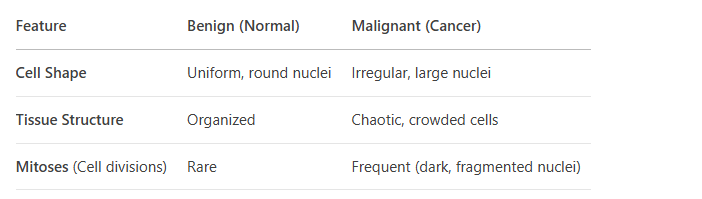


**Benign (Fibroadenoma):**

https://example.com/benign.jpg

Uniform cells, orderly arrangement.

**Malignant (Ductal Carcinoma):**

https://example.com/malignant.jpg

Irregular nuclei, cells invading surrounding tissue.

**3. Subtypes in BreakHis Dataset**

Malignant Types (SOB Folders):

***Ductal Carcinoma (80% of cases):***

Starts in milk ducts.

Image Clue: Cells form "duct-like" patterns.

***Lobular Carcinoma:***

Starts in milk-producing lobules.

Image Clue: Cells grow in single-file lines.

***Mucinous/Papillary Carcinoma (Rarer):***

Contains mucus/papillae (finger-like projections).


**Benign Types:**

Adenosis: Enlarged lobules.

Fibroadenoma: Solid, rubbery lumps.





4. **Why This Matters for Your AI Model
Your CNN will learn** :

Malignant cells have dark, irregular nuclei (high-grade tumors).

Benign cells have uniform staining and spacing.


**Attention/Grad-CAM will show**:

Which regions the model "thinks" are cancerous (e.g., clustered dark nuclei).



"*AI mimics how pathologists look for nuclear pleomorphism (variation in size/shape of nuclei).*"

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/content/drive/MyDrive/breast_cancer_detection_proj/breast'  # Adjust to your path
benign_dir = os.path.join(base_dir, 'benign/SOB')
malignant_dir = os.path.join(base_dir, 'malignant/SOB')
output_dir = '/content/data'  # New folder for split data

# Create train/test folders
os.makedirs(os.path.join(output_dir, 'train/benign'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/malignant'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/benign'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/malignant'), exist_ok=True)

# List all images (recursively)
def list_images(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

print(f"Checking for images in: {benign_dir}")
benign_images = list_images(benign_dir)
print(f"Found {len(benign_images)} benign images.")

print(f"Checking for images in: {malignant_dir}")
malignant_images = list_images(malignant_dir)
print(f"Found {len(malignant_images)} malignant images.")


# Split into train/test (stratified)
benign_train, benign_test = train_test_split(benign_images, test_size=0.2, random_state=42)
malignant_train, malignant_test = train_test_split(malignant_images, test_size=0.2, random_state=42)

# Copy images to new folders
def copy_files(file_paths, destination):
    for path in file_paths:
        shutil.copy(path, destination)

copy_files(benign_train, os.path.join(output_dir, 'train/benign'))
copy_files(benign_test, os.path.join(output_dir, 'test/benign'))
copy_files(malignant_train, os.path.join(output_dir, 'train/malignant'))
copy_files(malignant_test, os.path.join(output_dir, 'test/malignant'))

print(f"Train: {len(benign_train)} benign, {len(malignant_train)} malignant")
print(f"Test: {len(benign_test)} benign, {len(malignant_test)} malignant")

Checking for images in: /content/drive/MyDrive/breast_cancer_detection_proj/breast/benign/SOB
Found 2480 benign images.
Checking for images in: /content/drive/MyDrive/breast_cancer_detection_proj/breast/malignant/SOB
Found 870 malignant images.
Train: 1984 benign, 696 malignant
Test: 496 benign, 174 malignant


**Data Augmentation (For Better Generalization)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift horizontally
    height_shift_range=0.1, # Randomly shift vertically
    shear_range=0.1,        # Shear transformations
    zoom_range=0.1,         # Random zoom
    horizontal_flip=True,   # Flip horizontally
    fill_mode='nearest'     # Fill missing pixels
)

# Validation/Test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

**Create Data Generators:**

In [ ]:
# Flow from directory for training data
train_generator = train_datagen.flow_from_directory(
    '/content/data/train',       # Path to training data
    target_size=(150, 150),      # Resize images
    batch_size=32,
    class_mode='binary',         # Binary classification
    classes=['benign', 'malignant']  # Ensure correct label mapping
)

# Flow from directory for validation data
val_generator = test_datagen.flow_from_directory(
    '/content/data/test',        # Using test as validation
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['benign', 'malignant']
)

Found 2680 images belonging to 2 classes.
Found 670 images belonging to 2 classes.


**Handle Class Imbalance:**

🔍 *Class Weights?*

When one class (e.g., benign) appears way more than the other (malignant), the model might get lazy and always predict the dominant class.

*👉 Class weights fix this by telling the model:*

“Hey! Mistakes on the rare class (malignant) are more serious — pay more attention!”

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")  # Should show higher weight for malignant

Class weights: {0: np.float64(0.6754032258064516), 1: np.float64(1.9252873563218391)}


This tells your model:

    “Penalize wrong malignant predictions more!”

**Building CNN model with Attention:**

**🤔 What is Attention (in Deep Learning)?**

Attention is a mechanism that helps the model focus on the most important parts of the input.

Imagine looking at a medical image — instead of treating all pixels equally, attention lets the model say:

    "This area looks suspicious — pay more attention here!"

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

def build_model(with_attention = True):
  model = Sequential()

  #convlutional base
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))

  #optimal attention layer
  if with_attention:
    model.add(AttentionLayer())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  return model

class AttentionLayer(Layer):
  def __init__(self):
    super().def__init__()

  def build(self, input_shape):
    self.attention = Sequential([
        Conv2D(1, (1,1), activation='sigmoid'),
        Multiply()
    ])

  def call(self, inputs):
    attention_mask = self.attention[0](inputs)
    return self.attention[1]([inputs, attention_mask])

**Compile and Train:**

In [ ]:
import tensorflow as tf
model = build_model(with_attention=True)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5297 - auc: 0.5812 - loss: 1.0515

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5307 - auc: 0.5824 - loss: 1.0478 - val_accuracy: 0.7060 - val_auc: 0.8528 - val_loss: 0.6080
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.7648 - auc: 0.8346 - loss: 0.4798 - val_accuracy: 0.8224 - val_auc: 0.9033 - val_loss: 0.3290
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8019 - auc: 0.8904 - loss: 0.3937 - val_accuracy: 0.7418 - val_auc: 0.9083 - val_loss: 0.5405
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8182 - auc: 0.9202 - loss: 0.3458 - val_accuracy: 0.8567 - val_auc: 0.9276 - val_loss: 0.3013
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8465 - auc: 0.9265 - loss: 0.3271 - val_accuracy: 0.8731 - val_auc: 0.9304 - val_loss: 0.2721
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8261 - auc: 0.9121 - loss: 0.3553 - val_accuracy: 0.8701 - val_auc: 0.9303 - val_loss: 0.2747
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accu

In [ ]:
# Evaluate on test data
test_generator = test_datagen.flow_from_directory(
    '/content/data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for correct labels
)

results = model.evaluate(test_generator)
print(f"Test Accuracy: {results[1]*100:.2f}% | AUC: {results[2]:.3f}")



Found 670 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 786ms/step - accuracy: 0.8652 - auc: 0.2984 - loss: 0.2882
Test Accuracy: 86.27% | AUC: 0.943


In [ ]:
print("Model layer names:", [layer.name for layer in model.layers])

Model layer names: ['conv2d_15', 'max_pooling2d_10', 'conv2d_16', 'max_pooling2d_11', 'attention_layer_4', 'flatten_1', 'dense_2', 'dense_3']


21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 844ms/step
Confusion Matrix:
[[411  85]
 [  7 167]]


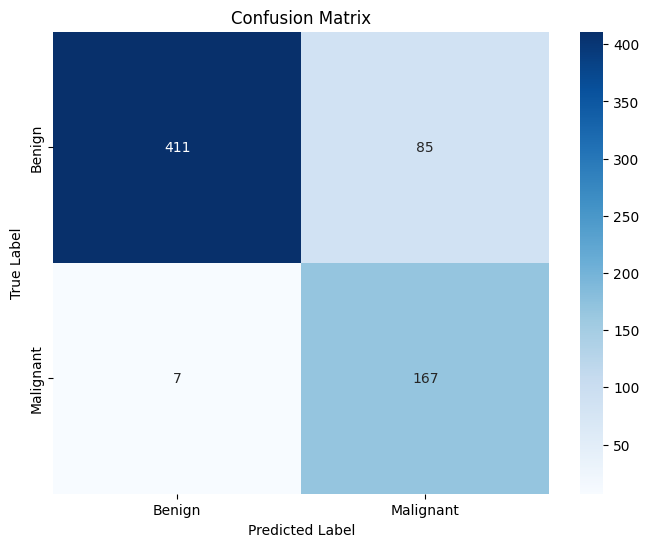

In [ ]:
# generate a code to see the confusion matrix of this

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten() # Convert probabilities to class labels

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# write a code to print the classification report

from sklearn.metrics import classification_report

# Print the classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.83      0.90       496
   Malignant       0.66      0.96      0.78       174

    accuracy                           0.86       670
   macro avg       0.82      0.89      0.84       670
weighted avg       0.90      0.86      0.87       670



1. **Critical Analysis of Results**

**Strengths:**

High Malignant Recall (96%): Very few false negatives (critical for cancer detection).

Good AUC (0.943): Strong overall ranking capability.

**Weaknesses:**

Low Malignant Precision (66%): Many false positives (benign cases flagged as malignant).

Class Imbalance: Only 174 malignant vs. 496 benign in test set.

In [ ]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs = model.predict(test_generator)[:, 0]
y_true = test_generator.classes

# Find optimal threshold (maximizing F1-score)
precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-7)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold: {optimal_threshold:.2f}")  # Likely ~0.3-0.5

21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 795ms/step
Optimal Threshold: 0.79


In [ ]:
y_pred = (y_probs > optimal_threshold).astype(int)  # Use optimized threshold

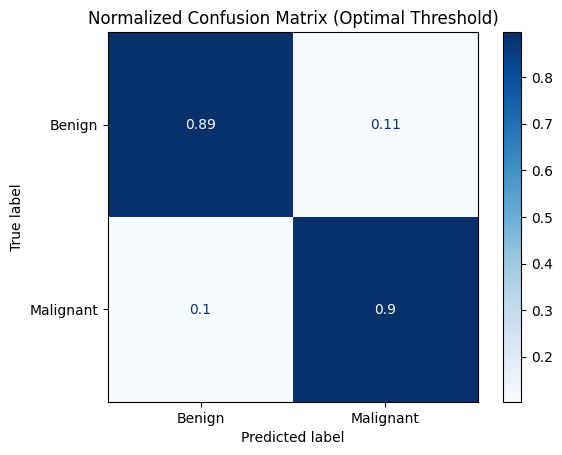

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=['Benign', 'Malignant'],
    cmap='Blues',
    normalize='true'
)
plt.title('Normalized Confusion Matrix (Optimal Threshold)')
plt.show()

Benign Recall (Specificity): 89%

11% of benign cases are misclassified as malignant (false positives)

Malignant Recall (Sensitivity): 90%

10% of cancers are missed (false negatives)

In [ ]:
# write a code to print the classification report

from sklearn.metrics import classification_report

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true,y_pred, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.89      0.92       496
   Malignant       0.74      0.90      0.81       174

    accuracy                           0.89       670
   macro avg       0.85      0.89      0.87       670
weighted avg       0.90      0.89      0.90       670



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


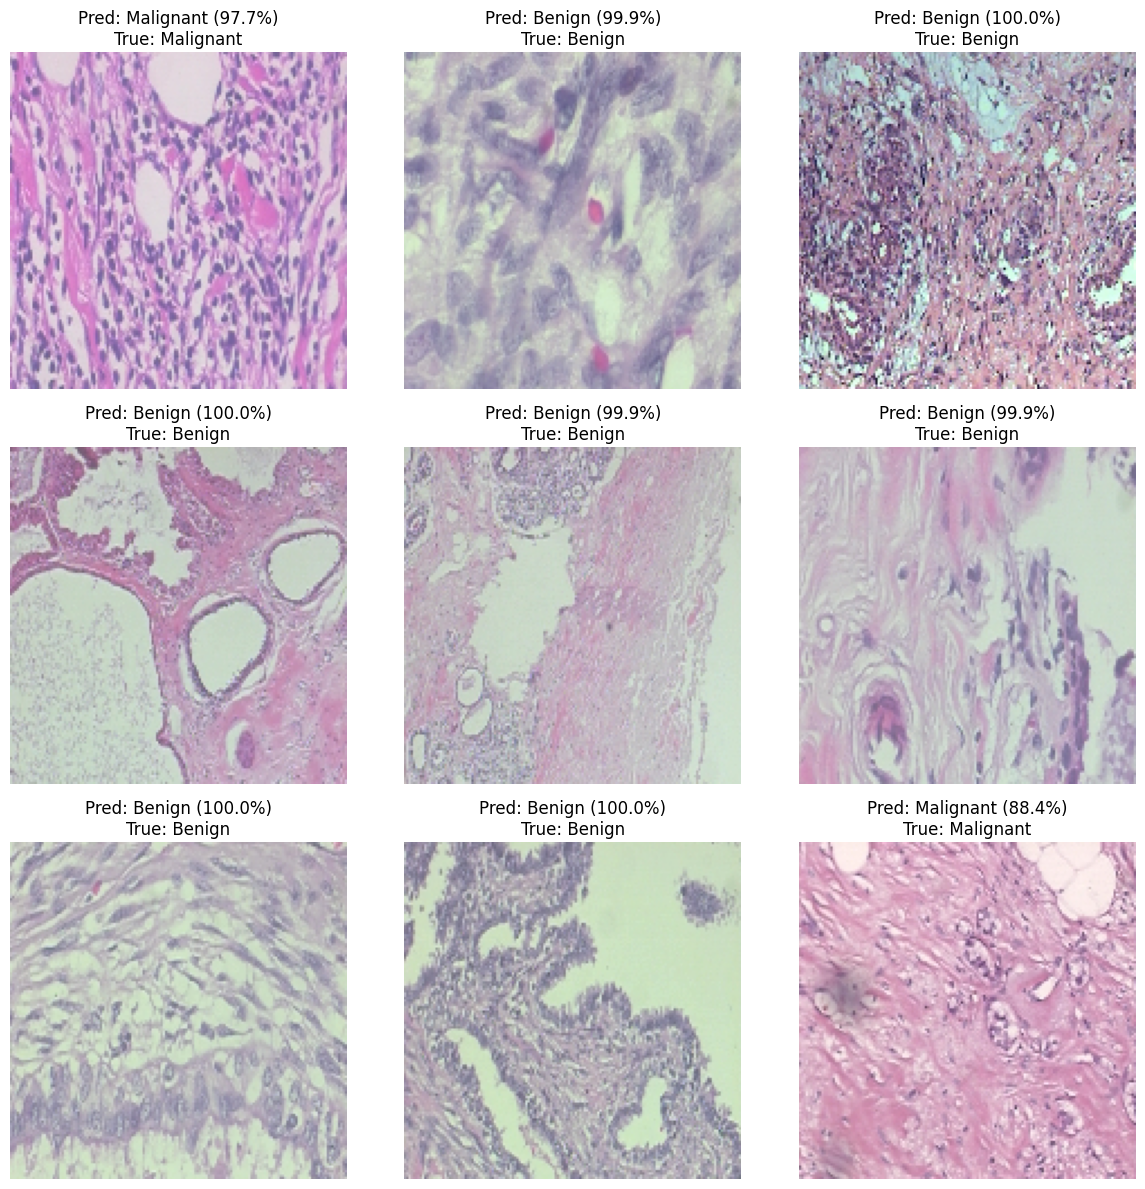

In [ ]:
#write the code to show sample images with true and prediction value

import matplotlib.pyplot as plt
import numpy as np
import random
class_labels = ['Benign', 'Malignant'] # Correct class labels for this dataset

# Make sure test_generator is defined and contains the test dataset
# Assuming test_generator is already defined as in the preceding code

# Get true labels (ensure this matches the images being displayed)
# The test_generator.classes gives the true labels for the entire generator
y_true = test_generator.classes

plt.figure(figsize=(12, 12)) # Increase figure size for better visualization

# Define the path to the test directory
test_dir = '/content/data/test'
img_size = (150, 150) # Define the target image size

# Get the list of filenames from the test generator
test_filenames = test_generator.filenames

for i in range(9):
    # Select a random index within the bounds of the test filenames
    idx = random.randint(0, len(test_filenames) - 1)

    # Get the image path using the filename and the base test directory
    img_path = os.path.join(test_dir, test_filenames[idx])

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0 # Rescale the image
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Get the prediction for this specific image
    prediction = model.predict(img_array)[0][0]

    # Determine predicted and true labels based on the prediction and the corresponding true label
    pred_label = class_labels[1] if prediction > optimal_threshold else class_labels[0]
    true_label = class_labels[y_true[idx]] # Use the true class index from test_generator.classes

    # Calculate confidence
    confidence = prediction if prediction > optimal_threshold else 1 - prediction

    # Display the image and its labels
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label} ({confidence*100:.1f}%)\nTrue: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save('cancer_model.keras')  # ✅ Modern format (smaller, faster)


In [ ]:
# # # Load with custom layer mapping
# # loaded_model = tf.keras.models.load_model(
# #     'cancer_model.keras',
# #     custom_objects={'AttentionLayer': AttentionLayer}  # 👈 Tell Keras about your layer
# )

In [ ]:
# import numpy as np
# from PIL import Image

# def predict(image_path, model_path='cancer_model.keras'):
#     model = tf.keras.models.load_model(model_path)
#     img = Image.open(image_path).resize((150, 150))
#     img_array = np.array(img) / 255.0
#     prob = model.predict(img_array[np.newaxis, ...])[0][0]
#     return {"malignant_probability": float(prob), "class": "Malignant" if prob > 0.5 else "Benign"}

# # Usage
# print(predict("path/to/test_image.png"))